# Estimativa do Valor de Aluguel na cidade de Santos/SP

## Fase 1 - Definição do problema a ser resolvido

Como objetivo do projeto, queremos criar um modelo de machine learning em que será calculado um valor estimado do aluguel do imóvel baseado nas características dele, como por exemplo: área (em m²), número de quartos e banheiros, e o bairro em que está localizado.

## Fase 2 - Preparação e exploração dos dados

### Coleta dos dados

Para coletar os dados, foi desenvolvido um webscrapper (webscrapper.py) que coleta os imóveis disponíveis para alugar na cidade de Santos, que foram anunciados no site Viva Real.

Após a coleta dos imóveis, foi desenvolvido um script em que converte o endereço dos imóveis em CEP (get_cep.py) e outro script que converte o CEP em coordenadas geográficas (get_geo.py).

O resultado dessas coletas são 2 arquivos de formato .csv:

- santos_rent.csv = arquivo contendo os imóveis coletados
- santos_geo.csv = arquivo contendo as coordenadas geográficas dos endereços de Santos

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, norm

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Carregando datasets
arquivo = "santos_rent.csv"
santos = pd.read_csv(arquivo)
arquivo2 = "santos_geo.csv"
end = pd.read_csv(arquivo2)

### Preparação e transformação dos dados

In [3]:
# Merge nos datasets pela coluna "endereço"
data = santos.merge(end, on='endereco')
data = data.drop(['Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0.1' ] , axis = 1)
data

,rent,endereco,rooms,bathroom,parking,area,CEP,Bairro,lat,long
0,1450,Rua Carlos Afonseca,1.0,1.0,1.0,55,11055240,Gonzaga,-23.968787,-46.331394
1,1450,Rua Carlos Afonseca,1.0,1.0,1.0,55,11055240,Gonzaga,-23.968787,-46.331394
2,1450,Rua Carlos Afonseca,1.0,1.0,1.0,55,11055240,Gonzaga,-23.968787,-46.331394
3,8500,Avenida Doutor Epitácio Pessoa,3.0,2.0,3.0,158,11045301,Boqueirão,-23.964803,-46.323585
4,8500,Avenida Doutor Epitácio Pessoa,3.0,2.0,3.0,158,11045301,Boqueirão,-23.964803,-46.323585
...,...,...,...,...,...,...,...,...,...,...
8733,9000,Rua Colômbia,4.0,6.0,4.0,237,11045320,Boqueirão,-23.970110,-46.321890
8734,1838,Rua Bolívia,3.0,1.0,3.0,65,11035210,Aparecida,-23.976088,-46.303332
8735,1600,Rua Pereira Barreto,1.0,1.0,1.0,48,11065110,Gonzaga,-23.966544,-46.335180
8736,1500,Rua Prefeito Antenor Bué,3.0,2.0,3.0,92,11040020,Embaré,-23.975130,-46.310414


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8738 entries, 0 to 8737
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rent      8738 non-null   int64  
 1   endereco  8738 non-null   object 
 2   rooms     8731 non-null   float64
 3   bathroom  8730 non-null   float64
 4   parking   8731 non-null   float64
 5   area      8738 non-null   int64  
 6   CEP       8738 non-null   int64  
 7   Bairro    8738 non-null   object 
 8   lat       8738 non-null   float64
 9   long      8738 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 750.9+ KB


In [5]:
data.isna().sum()

rent        0
endereco    0
rooms       7
bathroom    8
parking     7
area        0
CEP         0
Bairro      0
lat         0
long        0
dtype: int64

In [6]:
# Removendo entradas sem os campos "bathroom" ou "rooms" preenchidos
data = data.dropna(how = 'any', subset=['bathroom', 'rooms'])
data.isna().sum()

rent        0
endereco    0
rooms       0
bathroom    0
parking     0
area        0
CEP         0
Bairro      0
lat         0
long        0
dtype: int64

In [7]:
# Removendo as entradas duplicadas
data.drop_duplicates(subset =["area", "rooms","bathroom","parking","CEP"], 
                     keep = "first", inplace = True) 

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
data.shape

(4125, 10)

In [9]:
# Verificando se possui algum valor sem preenchimento
data.isna().sum()

rent        0
endereco    0
rooms       0
bathroom    0
parking     0
area        0
CEP         0
Bairro      0
lat         0
long        0
dtype: int64

In [10]:
# Calculando o valor por metro quadrado
data['value_per_area'] = data['rent']/data['area']

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
data.describe()

,rent,rooms,bathroom,parking,area,CEP,lat,long,value_per_area
count,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4.125000e+03,4125.000000,4125.000000,4125.000000
mean,3974.412848,2.352727,2.390303,2.352727,119.602424,1.104940e+07,-23.965420,-46.326168,36.165176
std,5970.559850,0.969939,1.347089,0.969939,79.383573,1.596602e+04,0.010373,0.014041,82.513932
min,250.000000,1.000000,1.000000,1.000000,10.000000,1.101001e+07,-23.989809,-46.382552,4.411765
25%,2200.000000,2.000000,1.000000,2.000000,70.000000,1.104000e+07,-23.968279,-46.334000,23.809524
50%,3000.000000,2.000000,2.000000,2.000000,96.000000,1.105002e+07,-23.964803,-46.327691,30.000000
75%,4300.000000,3.000000,3.000000,3.000000,147.000000,1.106047e+07,-23.958225,-46.321602,40.462428
max,237624.000000,20.000000,13.000000,20.000000,750.000000,1.109010e+07,-23.927146,-46.297092,4400.000000


([<matplotlib.axis.XTick at 0x1f15be52b48>,
 <a list of 10 Text major ticklabel objects>)

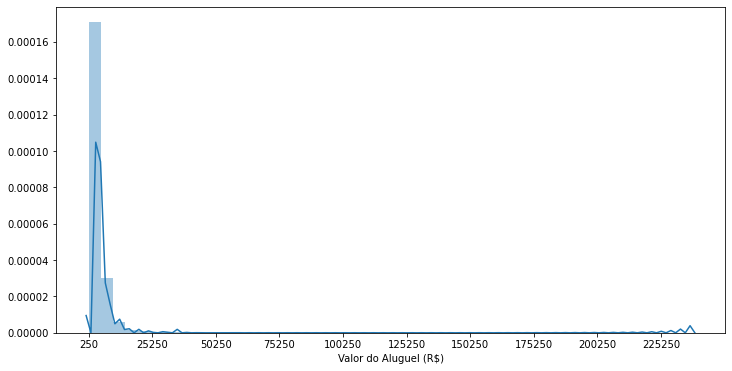

In [12]:
plt.figure(figsize=(12, 6))
sns.distplot(data['rent']).set(xlabel='Valor do Aluguel (R$)')
plt.xticks(np.arange(data['rent'].min(), data['rent'].max(), step=25000))

Como podemos ver, temos um outlier muito acima dos valores coletados. Vamos removê-lo e ver como ficará o gráfico de distribuição.

In [13]:
data = data.query('rent < 200000')

([<matplotlib.axis.XTick at 0x1f15dfd3c88>,
 <a list of 12 Text major ticklabel objects>)

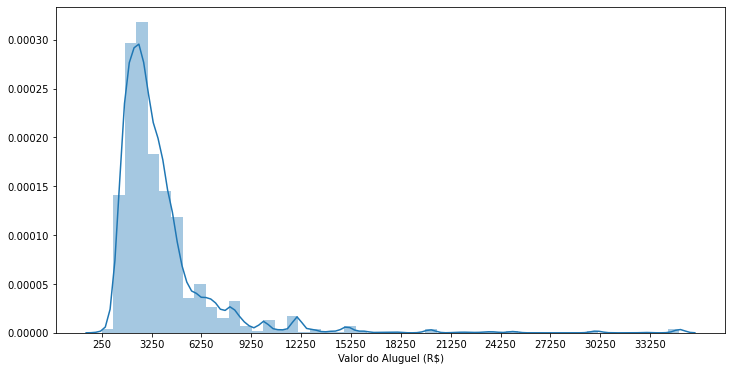

In [14]:
plt.figure(figsize=(12, 6))
sns.distplot(data['rent']).set(xlabel='Valor do Aluguel (R$)')
plt.xticks(np.arange(data['rent'].min(), data['rent'].max(), step=3000))

O outlier foi removido, e agora podemos observar o gráfico de distribuição mais real.

Vamos agora observar o gráfico de distribuição da variável "area".

([<matplotlib.axis.XTick at 0x1f15dffda88>],
 <a list of 1 Text major ticklabel objects>)

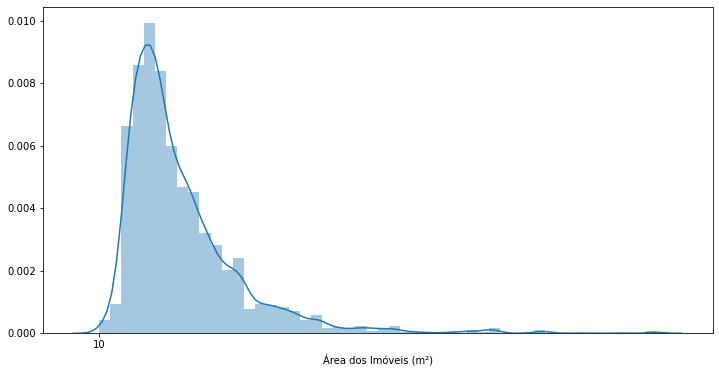

In [15]:
plt.figure(figsize=(12, 6))
sns.distplot(data['area']).set(xlabel='Área dos Imóveis (m²)')
plt.xticks(np.arange(data['area'].min(), data['area'].max(), step=3000))

Como podemos observar, o gráfico de distribuição das variáveis "area" e "rent" possuem assimetria positiva. Podemos calcular o coeficiente de assimetria (skewness) utilizando a função "skew".

- Se o resultado estiver entre -0.5 e 0.5, podemos concluir que a distribuição é aproximadamente simétrica
- Se o resultado estiver entre -0.5 e -1.0 ou 0.5 e 1.0, podemos concluir que a distribuição é moderadamente assimétrica
- Se o resultado for menor que -1.0 ou maior do que 1.0, podemos concluir que a distribuição é altamente assimétrica

In [16]:
skew(data['rent'])

4.63556694763996

In [17]:
skew(data['area'])

2.5921133220279557

Comparando com os coeficientes de assimetria, podemos concluir que ambos os campos possuem uma distribuição altamente assimétrica.

Para tornar essas distribuições simétricas (esse processo também é conhecido como Normalização dos dados) podemos aplicar a Transformação Logarítimica para ambas as variáveis.

In [18]:
data['lrent'] = np.log1p(data['rent'])
data['larea'] = np.log1p(data['area'])

[Text(0.5, 0, 'Área dos Imóveis (m²)')]

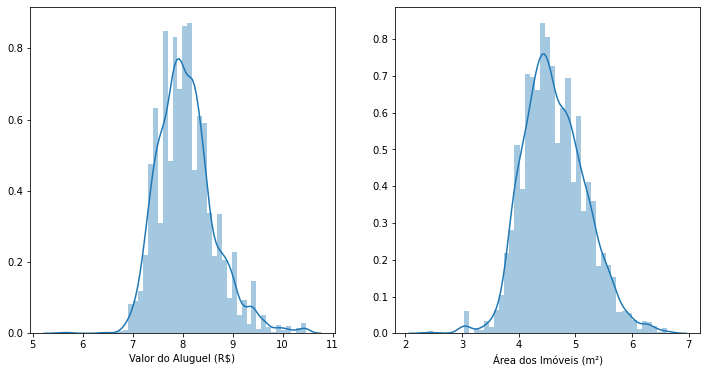

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.distplot(data['lrent']).set(xlabel='Valor do Aluguel (R$)')

plt.subplot(1, 2, 2)
sns.distplot(data['larea']).set(xlabel='Área dos Imóveis (m²)')

In [20]:
print("Skewness (area): "+ str(skew(data['larea'])))
print("Skewness (rent): "+ str(skew(data['lrent'])))

Skewness (area): 0.3223275493500189
Skewness (rent): 0.7669972494917753


Como podemos observar, os gráficos de distribuição tiveram sua assimetria muito reduzidas após aplicar a transformação logarítmica.

### Limpeza dos dados

Para uma melhor performance do modelo, optamos por manter apenas os Bairros que possuem mais de 100 imóveis coletados, já que para alguns bairros poderia apresentar inconsistência no resultado devido a falta de informações sobre algumas características específicas de imóvel.

In [21]:
data['Bairro'].value_counts()

Boqueirão            998
Gonzaga              907
Ponta da Praia       514
Aparecida            265
Embaré               257
José Menino          235
Vila Mathias         201
Marapé               193
Campo Grande         123
Pompéia              114
Vila Belmiro          73
Encruzilhada          63
Macuco                60
Paquetá               50
Rádio Clube           21
Estuário              13
Centro                 8
Saboó                  6
Chico de Paula         5
São Jorge              3
Areia Branca           3
Castelo                3
Morro Nova Cintra      2
Santa Maria            2
Jabaquara              1
Morro Penha            1
Bom Retiro             1
Vila Nova              1
Name: Bairro, dtype: int64

In [22]:
counts = data['Bairro'].value_counts()
data = data[~data['Bairro'].isin(counts[counts < 101].index)]

In [23]:
data.groupby(['Bairro','rooms'])['rent'].count()

Bairro          rooms
Aparecida       1.0       53
                2.0       93
                3.0       84
                4.0       34
                5.0        1
Boqueirão       1.0      196
                2.0      318
                3.0      303
                4.0      173
                5.0        8
Campo Grande    1.0       19
                2.0       84
                3.0       18
                4.0        2
Embaré          1.0       28
                2.0       93
                3.0      111
                4.0       23
                5.0        2
Gonzaga         1.0      170
                2.0      336
                3.0      314
                4.0       70
                5.0       16
                20.0       1
José Menino     1.0       62
                2.0      116
                3.0       49
                4.0        8
Marapé          1.0       31
                2.0      115
                3.0       41
                4.0        3
                5.0  

Como observado, temos muito poucas informações sobre os imóveis com 5 ou mais quartos. 

Por isso, manteremos apenas os imóveis com até 4 quartos.

In [24]:
data = data.query('rooms < 5')

In [25]:
data.groupby(['Bairro','rooms'])['rent'].count()

Bairro          rooms
Aparecida       1.0       53
                2.0       93
                3.0       84
                4.0       34
Boqueirão       1.0      196
                2.0      318
                3.0      303
                4.0      173
Campo Grande    1.0       19
                2.0       84
                3.0       18
                4.0        2
Embaré          1.0       28
                2.0       93
                3.0      111
                4.0       23
Gonzaga         1.0      170
                2.0      336
                3.0      314
                4.0       70
José Menino     1.0       62
                2.0      116
                3.0       49
                4.0        8
Marapé          1.0       31
                2.0      115
                3.0       41
                4.0        3
Pompéia         1.0       22
                2.0       39
                3.0       48
                4.0        5
Ponta da Praia  1.0       93
                2.0  

In [26]:
data.groupby(['Bairro','bathroom'])['rent'].count()

Bairro        bathroom
Aparecida     1.0         89
              2.0         67
              3.0         50
              4.0         30
              5.0         20
                          ..
Vila Mathias  2.0         70
              3.0         27
              4.0         15
              5.0         20
              6.0          3
Name: rent, Length: 68, dtype: int64

O mesmo foi observado para os imóves com 6 ou mais banheiros. 

Por isso estaremos eliminando os imóveis que possuem mais do que 5 banheiros.

In [27]:
data = data.query('bathroom < 6')

#### Remoção de Outliers

Os estatísticos desenvolveram diversas maneiras de identificar o que pode e o que não pode ser considerado um outlier.
Uma regra bastante usada afirma que um dado é um outlier quando ele é maior que 1.5 * FIQ acima do terceiro quartil ou abaixo do primeiro quartil. 

Em outras palavras, outliers baixos estão abaixo de Q1 - 1.5 * FIQ e outliers altos estão acima de Q3 + 1.5 * FIQ.

Para isso, iremos analisar e aplicar essa técnica no campo "value_per_area", afim de remover as entradas contendo o valor por metro quadrado fora da realidade.

In [28]:
# Cálculo do coeficiente de assimetria
skew(data['value_per_area'])

5.209514027850611

In [29]:
# Transformação logarítmica
data['value_per_area'] = np.log1p(data['value_per_area'])

In [30]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [31]:
# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(data['value_per_area'])

# Non-Outlier Subset of the Given Dataset
data_ = data[nonOutlierList]

data_

,rent,endereco,rooms,bathroom,parking,area,CEP,Bairro,lat,long,value_per_area,lrent,larea
0,1450,Rua Carlos Afonseca,1.0,1.0,1.0,55,11055240,Gonzaga,-23.968787,-46.331394,3.309215,7.280008,4.025352
3,8500,Avenida Doutor Epitácio Pessoa,3.0,2.0,3.0,158,11045301,Boqueirão,-23.964803,-46.323585,4.003644,9.047939,5.068904
6,4100,Rua República do Equador,2.0,4.0,2.0,111,11030150,Ponta da Praia,-23.982137,-46.299935,3.635925,8.318986,4.718499
15,2380,Rua João Caetano,2.0,2.0,2.0,90,11070310,Campo Grande,-23.958225,-46.337921,3.312164,7.775276,4.510860
18,5200,Avenida Rei Alberto I,3.0,3.0,3.0,132,11030381,Ponta da Praia,-23.988478,-46.298466,3.698680,8.556606,4.890349
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8729,7000,Rua Firmino Barbosa,4.0,3.0,4.0,330,11055130,Boqueirão,-23.967363,-46.326685,3.100638,8.853808,5.802118
8730,2000,Rua Vereador Henrique Soler .,1.0,1.0,1.0,60,11030011,Ponta da Praia,-23.982473,-46.297624,3.536117,7.601402,4.110874
8732,2900,Praça Nossa Senhora Aparecida,2.0,3.0,2.0,134,11025025,Aparecida,-23.972956,-46.302527,3.119797,7.972811,4.905275
8734,1838,Rua Bolívia,3.0,1.0,3.0,65,11035210,Aparecida,-23.976088,-46.303332,3.376800,7.516977,4.189655


([<matplotlib.axis.XTick at 0x1f15e06cf08>],
 <a list of 1 Text major ticklabel objects>)

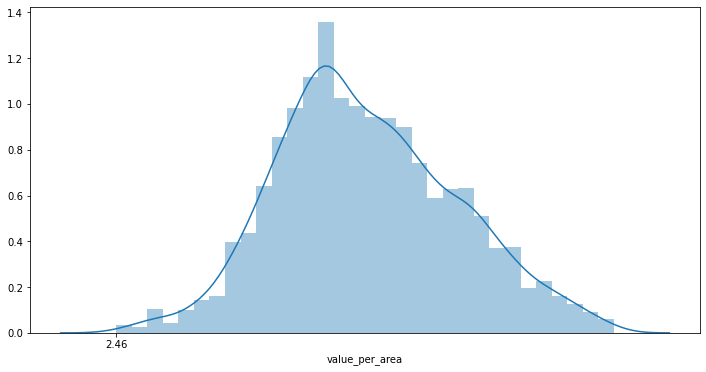

In [32]:
plt.figure(figsize=(12, 6))
sns.distplot(data_['value_per_area'])
plt.xticks(np.arange(data_['value_per_area'].min(), data_['value_per_area'].max(), step=10))

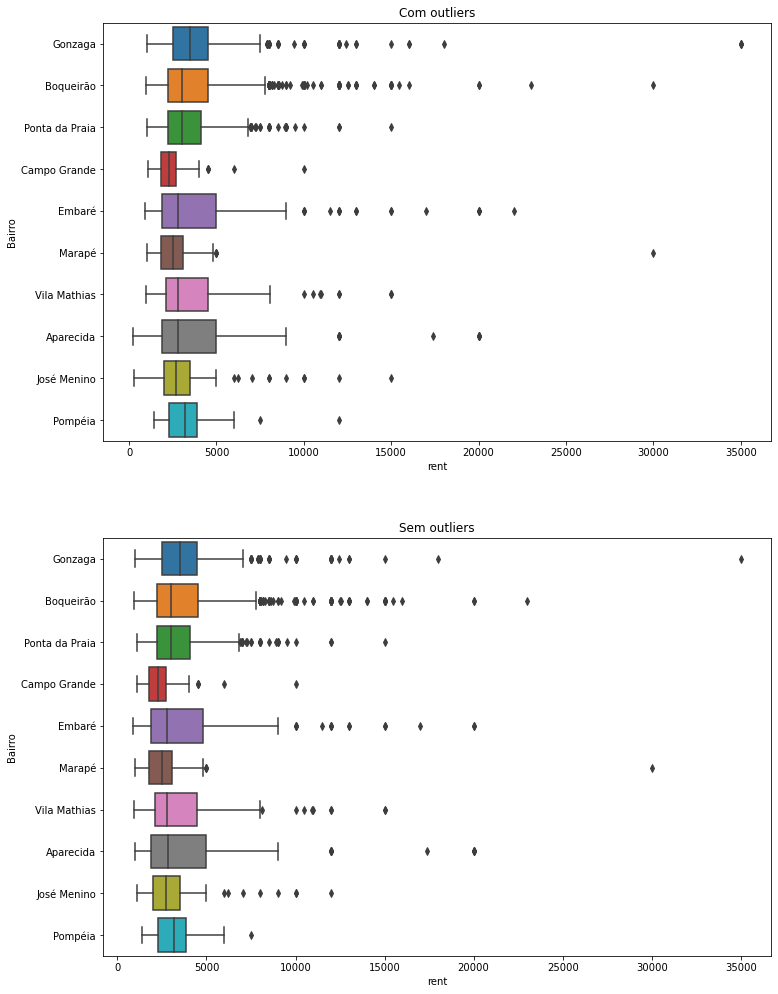

In [33]:
plt.figure(figsize=(12, 15))

plt.subplot(2, 1, 1)
plt.title('Com outliers')
sns.boxplot(data['rent'], data['Bairro'])

plt.subplot(2, 1, 2)
plt.title('Sem outliers')
sns.boxplot(data_['rent'], data_['Bairro'])

plt.tight_layout(pad=5.0)
plt.show()

### Análise exploratória dos dados

([<matplotlib.axis.XTick at 0x1f15e37d708>,
 <a list of 12 Text major ticklabel objects>)

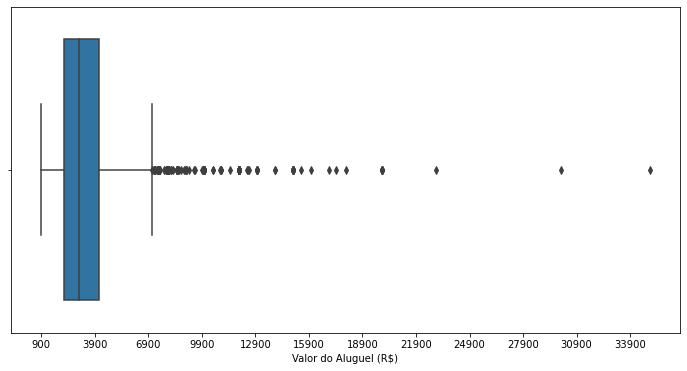

In [34]:
plt.figure(figsize=(12, 6))

sns.boxplot(data_['rent']).set(xlabel='Valor do Aluguel (R$)')
plt.xticks(np.arange(data_['rent'].min(), data_['rent'].max(), step=3000))

([<matplotlib.axis.XTick at 0x1f15ec9e088>,
 <a list of 3 Text major ticklabel objects>)

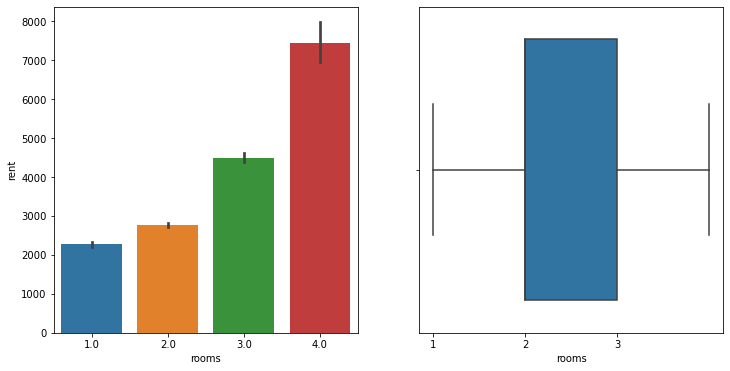

In [35]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=data_['rooms'], y=data_['rent'])

plt.subplot(1, 2, 2)
sns.boxplot(x=data_['rooms'])
plt.xticks(np.arange(data_['rooms'].min(), data_['rooms'].max(), step=1))

([<matplotlib.axis.XTick at 0x1f15ed74e08>,
 <a list of 4 Text major ticklabel objects>)

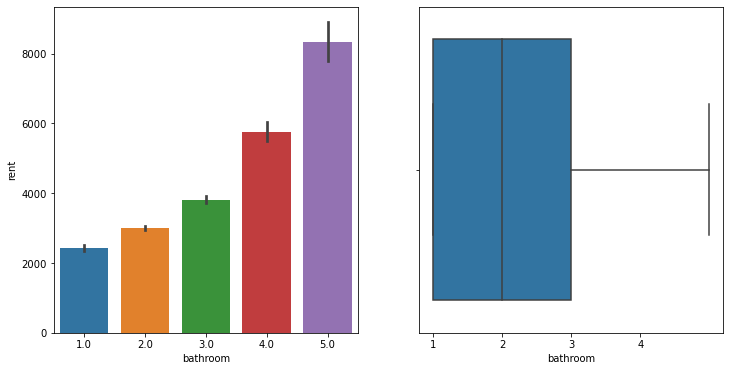

In [36]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=data_['bathroom'], y=data_['rent'])

plt.subplot(1, 2, 2)
sns.boxplot(x=data_['bathroom'])
plt.xticks(np.arange(data_['bathroom'].min(), data_['bathroom'].max(), step=1))

([<matplotlib.axis.XTick at 0x1f15ee78f08>,
 <a list of 3 Text major ticklabel objects>)

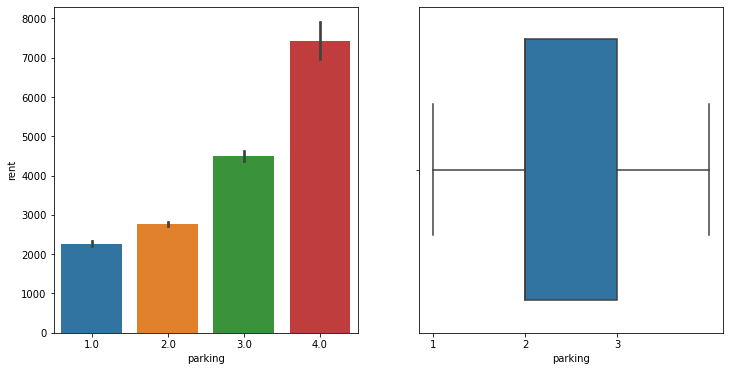

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=data_['parking'], y=data_['rent'])

plt.subplot(1, 2, 2)
sns.boxplot(x=data_['parking'])
plt.xticks(np.arange(data_['parking'].min(), data_['parking'].max(), step=1))

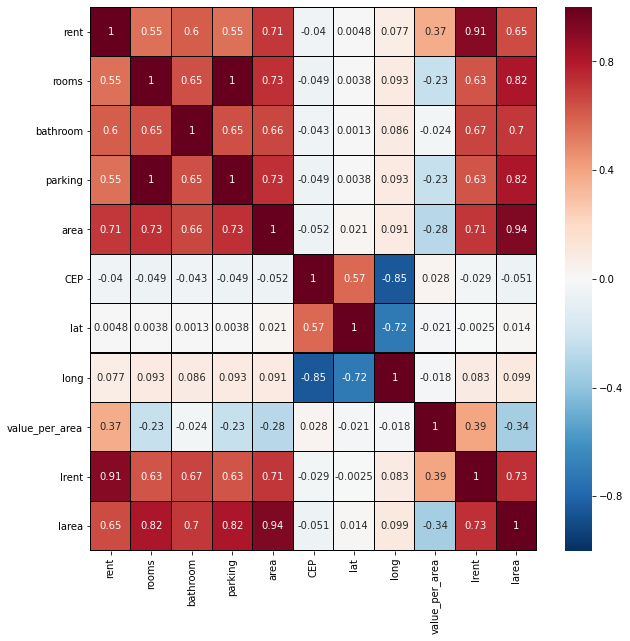

In [38]:
plt.figure(figsize=(10, 10))

numdata_ = data_._get_numeric_data()
var_num_corr = numdata_.corr()

sns.heatmap(var_num_corr, vmin=-1, vmax=1, annot=True, linewidth=0.01, linecolor='black', cmap='RdBu_r')

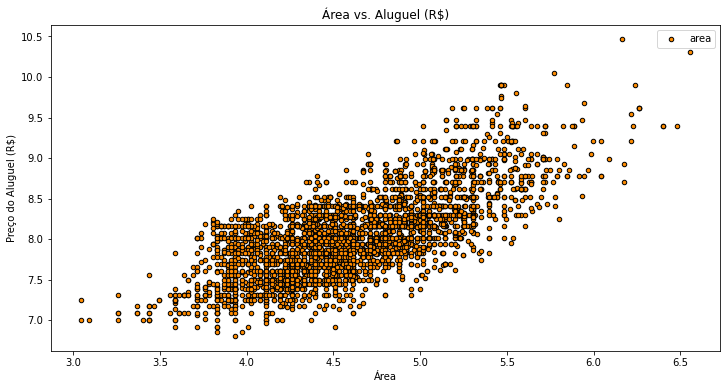

In [39]:
plt.figure(figsize=(12, 6))
plt.scatter(data_['larea'],data_['lrent'], s=20, edgecolor="black",c="darkorange", label="area")
plt.xlabel("Área")
plt.ylabel("Preço do Aluguel (R$)")
plt.title("Área vs. Aluguel (R$)")
plt.legend()
plt.show()

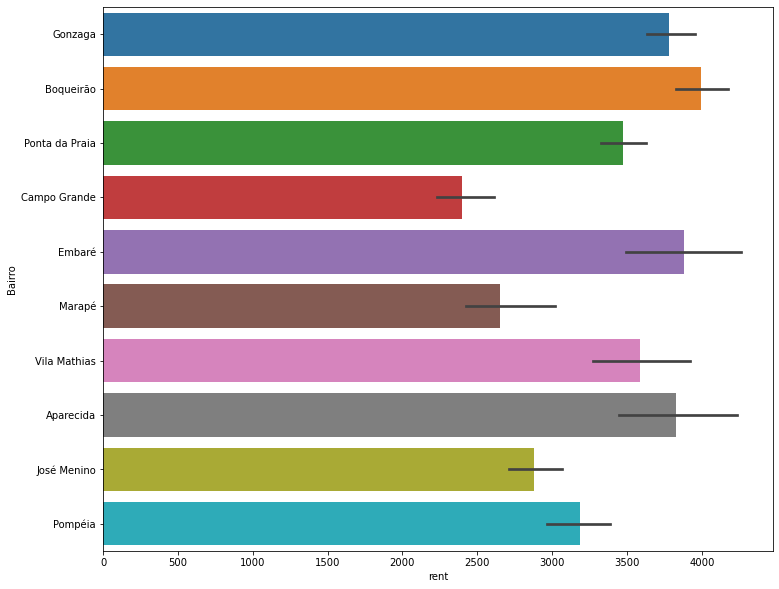

In [40]:
plt.figure(figsize=(12, 10))

sns.barplot(y=data_['Bairro'], x=data_['rent'])

In [41]:
import gmaps 

gmaps.configure(api_key='SuaKeyAqui')

fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
  data[['lat','long']],
  weights=data['rent'],
  max_intensity = 6000,
  point_radius=4.0
)

fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Treinamento do Modelo

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# ML models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [43]:
catTransformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder()
    )])

In [44]:
numTransformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [45]:
cols = ['larea','rooms','bathroom','parking','Bairro']

X = data_[cols]
X.head()

,larea,rooms,bathroom,parking,Bairro
0,4.025352,1.0,1.0,1.0,Gonzaga
3,5.068904,3.0,2.0,3.0,Boqueirão
6,4.718499,2.0,4.0,2.0,Ponta da Praia
15,4.510860,2.0,2.0,2.0,Campo Grande
18,4.890349,3.0,3.0,3.0,Ponta da Praia


In [46]:
for col in X:
    X = X.astype('category')
X['larea'] = X['larea'].astype('float64')
X.dtypes


larea        float64
rooms       category
bathroom    category
parking     category
Bairro      category
dtype: object

In [47]:
y = data_['lrent']
y

0       7.280008
3       9.047939
6       8.318986
15      7.775276
18      8.556606
          ...   
8729    8.853808
8730    7.601402
8732    7.972811
8734    7.516977
8736    7.313887
Name: lrent, Length: 3626, dtype: float64

In [48]:
X.dtypes

larea        float64
rooms       category
bathroom    category
parking     category
Bairro      category
dtype: object

In [49]:
catFeatures = X.select_dtypes(include=['category']).columns
catFeatures

Index(['rooms', 'bathroom', 'parking', 'Bairro'], dtype='object')

In [50]:
numFeatures = X.select_dtypes(include=['float64','int64']).columns
numFeatures

Index(['larea'], dtype='object')

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numTransformer, numFeatures),
        ('categoric', catTransformer, catFeatures)
    ])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [53]:
regressors = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(),
    LinearRegression(),
    XGBRegressor()
]

In [54]:
np.random.seed(42)

for regressor in regressors:
    
    estimator = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])    
    estimator.fit(X_train, y_train)
    preds = estimator.predict(X_test)
    
    print(regressor)

    print('MAE:', mean_absolute_error(y_test, preds))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))
    print('R2:', r2_score(y_test, preds))
    print('-' * 40)

DecisionTreeRegressor()
MAE: 0.29850528737777143
RMSE: 0.40012796056745026
R2: 0.38277025446450286
----------------------------------------
RandomForestRegressor()
MAE: 0.2610050000048902
RMSE: 0.3373774130830057
R2: 0.5611854148420632
----------------------------------------
SVR()
MAE: 0.2536647718484366
RMSE: 0.33088156844097344
R2: 0.5779205598710817
----------------------------------------
LinearRegression()
MAE: 0.2671357767893099
RMSE: 0.3380395707643174
R2: 0.5594612354702827
----------------------------------------
[23:04:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor()
MAE: 0.2486815530299898
RMSE: 0.31511897836731156
R2: 0.6171768733731331
----------------------------------------


Comparando as métricas de cada modelo treinado, podemos concluir que o modelo XGBRegressor apresentou o melhor resultado, e por isso iremos utilizá-lo para fazer os cálculos de estimativa de aluguel no nosso projeto.

In [55]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),                       
                       ('model', XGBRegressor())                                              
                      ])

In [56]:
params = {
        'model__learning_rate': np.arange(0.01, 0.1),
        'model__n_estimators': np.arange(100, 1000, step=50),
        'model__max_depth': np.arange(1, 20, step=2),
        'model__subsample': [0.8, 0.9, 1],
        'model__colsample_bytree': [0.8, 0.9, 1],
        'model__gamma': [0, 1, 3, 5]
         }

In [57]:
estimator = RandomizedSearchCV(pipe, cv=20, param_distributions=params, n_jobs=-1)
estimator.fit(X_train,y_train)

[23:06:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=20,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['larea'], dtype='object')),
                                                                              ('categoric',
                                                                               Pipeline(steps=[('ordinal',
                                                                                                OrdinalEncoder())]),
                                                                               Index(['rooms', 'bathroom', 'parking', 'Bairro'], dtype='object'))])),
                       

In [58]:
estimator.best_params_

{'model__subsample': 1,
 'model__n_estimators': 950,
 'model__max_depth': 5,
 'model__learning_rate': 0.01,
 'model__gamma': 0,
 'model__colsample_bytree': 0.8}

In [59]:
estimator = XGBRegressor(colsample_bytree=0.8,
                           gamma=0, 
                           learning_rate=0.01, 
                           max_depth=5, 
                           n_estimators=950, 
                           subsample=1)

In [60]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),    
    ('model', XGBRegressor())    
])

In [61]:
model.fit(X_train, y_train)

[23:06:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['larea'], dtype='object')),
                                                 ('categoric',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  Index(['rooms', 'bathroom', 'parking', 'Bairro'], dtype='object'))])),
                ('model', XGBRegressor())])

In [62]:
preds = model.predict(X_test)

In [63]:
print('MAE:', mean_absolute_error(y_test, preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))
print('R2:', r2_score(y_test, preds))

MAE: 0.2486815530299898
RMSE: 0.31511897836731156
R2: 0.6171768733731331


### Comparação entre as distribuições do resultado previsto e o resultado real

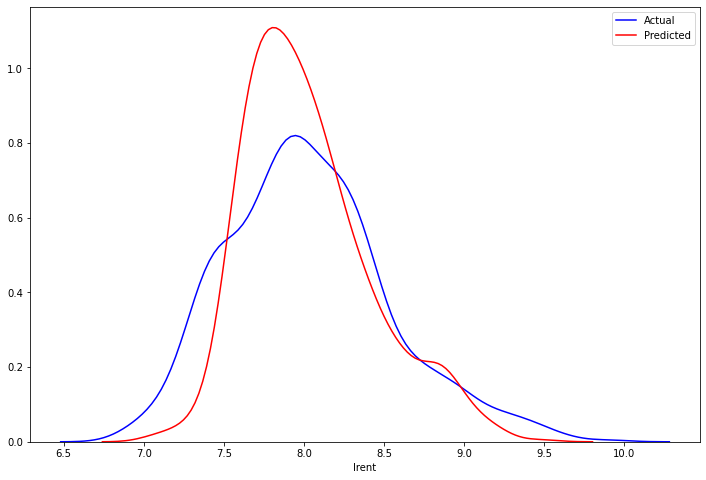

In [64]:
plt.figure(figsize=(12, 8))

sns.distplot(y_test, hist=False, color='b', label ='Actual')
sns.distplot(preds, hist=False, color='r', label = 'Predicted')

plt.show()

### Salvando o modelo em um arquivo (para ser utilizado no deploy do Projeto)

In [65]:
import joblib 

joblib.dump(model, 'model.pkl')  

['model.pkl']